# Anchor explanations for fashion MNIST

In [1]:
import alibi

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets, transforms
# import helper
from alibi.explainers import AnchorImage

### Load and prepare fashion MNIST data

In [45]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('data/fashion_mnist', download=True, train=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('data/fashion_mnist', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

print('x_train shape:', trainset)

x_train shape: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data/fashion_mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


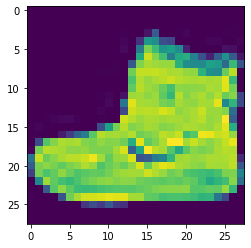

In [240]:
idx = 0
plt.imshow(trainset.data[idx])

Scale, reshape and categorize data

In [47]:
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255
# x_train = np.reshape(x_train, x_train.shape + (1,))
# x_test = np.reshape(x_test, x_test.shape + (1,))
# print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

### Define CNN model

In [211]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=5, padding=0)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*5*5, 256)  # max pool 두 번
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self, x):
        print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = x.view(-1, 32*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.dropout2(x))
        x = F.relu(self.fc3(x))
#         x = F.softmax(x)

        return x

In [212]:
cnn = CNN()

### Train model

In [137]:
import torch.optim as optim

learning_rate = 0.003
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

In [170]:
epochs = 5

for e in range(epochs):
    train_loss = 0.
    train_accuracy = 0.
    
    for images, labels in train_loader:
        
#         print(images.shape) #[16, 1, 28, 28]
        output = cnn(images)
#         print(labels.shape) #[64]
#         print(output.shape) #[64,10]
        loss = criterion(output, labels)
        
        # 가중치 갱신 후에는 수동으로 변화도를 0으로 만듭니다.
        optimizer.zero_grad()
        loss.backward()
        # All optimizers implement a step() method, that updates the parameters
        optimizer.step()
        
        train_loss += loss.item()
    
    print("EPOCH {}/{}".format(e+1, epochs))
    print("Train loss: {0:.3f}".format(train_loss / len(train_loader)))
#     print("Train accuracy: .3f".format(train_accuracy / len(train_loader)))
    print()

EPOCH 1/5
Train loss: 0.376

EPOCH 2/5
Train loss: 0.361

EPOCH 3/5
Train loss: 0.344

EPOCH 4/5
Train loss: 0.341

EPOCH 5/5
Train loss: 0.336



In [171]:
# Evaluate the model on test set

with torch.no_grad():
    test_loss = 0.
    test_accuracy = 0.
    
    for images, labels in test_loader:

        output = cnn(images)
        _, indices = torch.max(output, 1) # values, indices
        loss = criterion(output, labels)
        test_loss += loss.item()
        test_accuracy += sum(indices==labels)

    print("EPOCH {}/{}".format(e+1, epochs))
    print("Test loss: {0:.3f}".format(test_loss / len(test_loader)))
    print("Test accuracy: {0:.3f}".format(test_accuracy / len(test_loader)))
    print()

EPOCH 5/5
Test loss: 0.395
Test accuracy: 55.146



In [162]:
torch.max(output, 1)

torch.return_types.max(
values=tensor([16.6622, 13.3272,  9.8706, 32.0185, 25.4913, 11.8525, 11.1652, 23.4591,
        15.8951, 30.0439, 14.8189, 17.2794, 15.9507,  8.3540,  5.7180, 24.4420,
         7.3967,  9.3746,  5.2222, 17.0821, 14.4423, 24.5838, 13.9770, 10.0608,
         8.1193, 28.1792,  4.6691,  9.3532, 10.0274,  9.4668,  7.9000, 10.9974],
       grad_fn=<MaxBackward0>),
indices=tensor([4, 8, 3, 7, 3, 2, 4, 8, 7, 9, 8, 9, 0, 2, 0, 3, 5, 4, 4, 5, 2, 8, 0, 5,
        0, 5, 3, 0, 5, 0, 3, 9]))

### Define superpixels

Function to generate rectangular superpixels for a given image. Alternatively, use one of the built in methods. It is important to have meaningful superpixels in order to generate a useful explanation. Please check scikit-image's [segmentation methods](http://scikit-image.org/docs/dev/api/skimage.segmentation.html) (*felzenszwalb*, *slic* and *quickshift* built in the explainer) for more information on the built in methods.

In [199]:
images, label = next(iter(train_loader))
sample_image = images

In [177]:
def superpixel(image, size=(4, 7)):
    segments = np.zeros([image.shape[0], image.shape[1]])
    row_idx, col_idx = np.where(segments == 0)
    for i, j in zip(row_idx, col_idx):
        segments[i, j] = int((image.shape[1]/size[1]) * (i//size[0]) + j//size[1])
    return segments

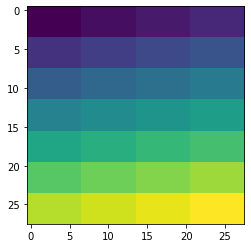

In [178]:
segments = superpixel(sample_image)
plt.imshow(segments);

### Define prediction function

In [202]:
# predict_fn = lambda x: cnn.predict(x)
predict_fn = lambda x: cnn(x)

In [222]:
# 한 장으로 cnn 돌리기
cnn(sample_image)

torch.Size([64, 1, 28, 28])


tensor([[0.0000, 0.0000, 0.0113, 0.1008, 0.1127, 0.0000, 0.0864, 0.0000, 0.0037,
         0.0181],
        [0.0000, 0.0000, 0.0000, 0.0684, 0.0674, 0.0000, 0.0263, 0.0000, 0.0000,
         0.0313],
        [0.0000, 0.0000, 0.0000, 0.0211, 0.0853, 0.0000, 0.0239, 0.0175, 0.0035,
         0.0104],
        [0.0000, 0.0000, 0.0000, 0.0447, 0.0397, 0.0000, 0.0421, 0.0222, 0.0000,
         0.0321],
        [0.0000, 0.0000, 0.0217, 0.0391, 0.0446, 0.0000, 0.0187, 0.0107, 0.0329,
         0.0000],
        [0.0000, 0.0000, 0.0325, 0.0679, 0.0918, 0.0000, 0.0655, 0.0000, 0.0208,
         0.0068],
        [0.0000, 0.0000, 0.0000, 0.0162, 0.0981, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0504],
        [0.0000, 0.0000, 0.0000, 0.0920, 0.1113, 0.0000, 0.0186, 0.0050, 0.0000,
         0.0516],
        [0.0000, 0.0000, 0.0206, 0.0939, 0.0875, 0.0000, 0.0032, 0.0000, 0.0436,
         0.0654],
        [0.0000, 0.0000, 0.0000, 0.0642, 0.1384, 0.0000, 0.0217, 0.0000, 0.0000,
         0.0147],
        [0

### Initialize anchor image explainer

In [206]:
sample_image.shape

torch.Size([64, 1, 28, 28])

In [217]:
image_shape

torch.Size([1, 28, 28])

In [ ]:
image_shape = sample_image.shape[1:]
explainer = AnchorImage(predict_fn, image_shape, segmentation_fn=superpixel)

### Explain a prediction

The explanation returns a mask with the superpixels that constitute the anchor.

Image to be explained:

In [226]:
images, label = next(iter(test_loader))
test_images = images

In [230]:
test_images[i].shape

torch.Size([1, 28, 28])

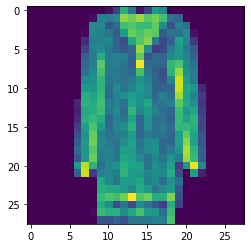

In [235]:
i = 1
image = test_images[i]
image = image.view(28, 28, -1)
plt.imshow(image[:,:,0]);

Model prediction:

In [239]:
cnn(image.reshape(1, 1, 28, 28)).argmax()

torch.Size([1, 1, 28, 28])


tensor(4)

The predicted category correctly corresponds to the class `Pullover`:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Generate explanation:

In [ ]:
explanation = explainer.explain(image, threshold=.95, p_sample=.8, seed=0)

Show anchor:

In [ ]:
plt.imshow(explanation.anchor[:,:,0]);

From the example, it looks like the end of the sleeve alone is sufficient to predict a pullover.